In [1]:
from battery import battery, logger
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline


#global config
log = logger("differenceSolarConsume", 100)
max_recharge_rate = 7000 # 最大充电速率7kw
max_solar_generation_rate = 20000 # 最大太阳能发20kwh
# batteries = [battery(max_recharge_rate, 100000, 0.96)]
base = "/Users/lishuyu/PycharmProjects/solarPowerEstimate/"
npy = f"{base}npy/"
plot = f"{base}plot/"

solarrad = np.load(npy+"solarrad.npy")

spring24 = np.load(npy+"spring24.npy")
summar24 = np.load(npy+"summer24.npy")
autumn24 = np.load(npy+"autumn24.npy")
winter24 = np.load(npy+"winter24.npy")
spring24 = np.sum(spring24, axis=0)/1000
summar24 = np.sum(summar24, axis=0)/1000
autumn24 = np.sum(autumn24, axis=0)/1000
winter24 = np.sum(winter24, axis=0)/1000


In [2]:
consume = []
for name in [spring24, summar24, autumn24, winter24]:
    for i in range(80):
        consume.append(list(name))
consume = np.array(consume)

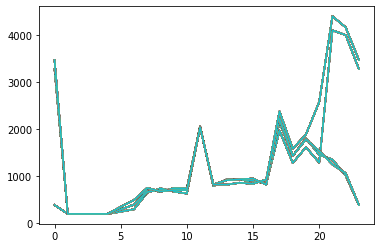

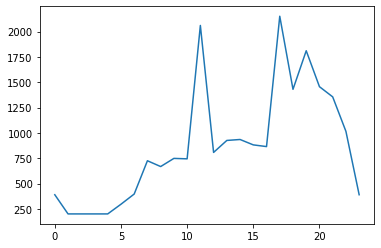

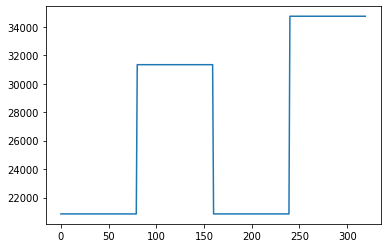

In [3]:
plt.plot(consume.T)
plt.show()
plt.plot(consume[0])
plt.show()
# plt.plot(solarrad[:24]*1000)
plt.plot(np.sum(consume, axis=1))
plt.show()

95


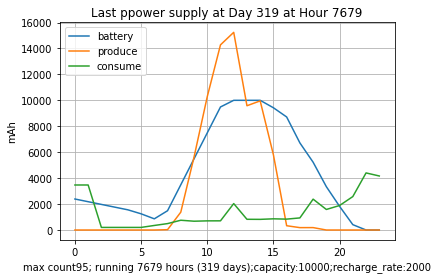

In [107]:
status = True
current_cap = []
max_nopower_count = 0
power_recharge_rate = 2000
power_capacity = 10000
power_efficency = 0.96

batteries = [battery(power_recharge_rate, power_capacity, power_efficency)]

year_round_status = []
for hour in range(320*24):
    sum_cap = sum([i.capacity for i in batteries])
    assert sum_cap >= 0
    current_cap.append(sum_cap)
    # print(sum_cap, end="\t")

    charge = solarrad[hour] * 1000
    discharge = spring24[hour%24]

    # print(charge, discharge)
    # time.sleep(1)
    

    if charge > discharge:
        remain = charge - discharge
        # print(f"Charge:{remain}", end="\t")
        for bat in batteries:   remain = bat.charge(remain)

    elif charge < discharge:

        sum_cap_cache = sum_cap
        

        pull = discharge - charge
        # print(f"Pull:{pull}", end="\t")
        for bat in batteries:   pull = bat.discharge(pull)
        
        if pull == 0 and not status:
            log.write("count_reset cause pull is zero")
            status = True
            # print(f"count_reset cause pull is zero")
            # time.sleep
        
        if pull > 0:
            log.write(f"{charge}, {discharge}, {sum([i.capacity for i in batteries])}, note: battery is later for one")
            log.write(f"No avaliable energy on day:{hour//24} hour:{hour}")

            if status:
                max_nopower_count+=1
                log.write("count_increase, set status to false")
                status = False
                # print(f"No avaliable energy on day:{hour//24}, {sum([i.capacity for i in batteries])}")
                # time.sleep(1)

    else:   log.write("balance")
    if status:
        year_round_status.append(1)
    else:
        year_round_status.append(0)
    


print(max_nopower_count)

current_cap.append(sum([i.capacity for i in batteries]))

plt.plot(current_cap[-24:], label="battery")
plt.plot(solarrad[hour-24:hour]*1000, label="produce")
plt.plot(consume.reshape(-1)[hour-24:hour], label="consume")
plt.title(f"Last ppower supply at Day {hour//24} at Hour {hour}")
plt.ylabel("mAh")
plt.xlabel(f"max count{max_nopower_count}; running {hour} hours ({hour//24} days);capacity:{power_capacity};recharge_rate:{power_recharge_rate}", )
plt.legend(loc="upper left")
plt.grid()
log.write(f"Save plot to {plot}Electric_power_capacity_plots/Electric_power_capacity{power_capacity}_PRR_{power_recharge_rate}_{max_nopower_count}.png")
plt.savefig(f"{plot}Electric_power_capacity_plots/Electric_power_capacity{power_capacity}_PRR_{power_recharge_rate}_{max_nopower_count}.png")
plt.show()

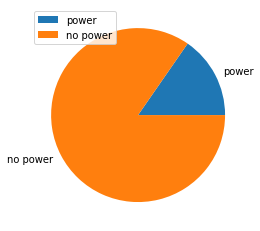

In [112]:
nopowerrate = sum(year_round_status)/len(year_round_status)*100
powerrate = 100 - nopowerrate
plt.pie([powerrate,nopowerrate], labels=['power','no power'])
plt.legend(loc="upper left")
plt.show()

In [64]:
import random, os
if not os.path.exists("daily"):os.mkdir("daily")

consume_random = consume/1000 + np.random.random(consume.shape)/4
produce_random = solarrad + np.random.random(solarrad.shape)/4

for i in range(10):
    index = random.randint(0,319)
    plt.plot(consume_random[index], label="consume")
    plt.plot(produce_random[index*24:(index+1)*24], label="produce")
    plt.xlabel("hour")
    plt.ylabel("kw * h")
    plt.legend(loc="upper left")
    plt.grid()
    plt.savefig(f"daily/{index}.png", dpi=800)
    plt.close()

for i in range(4):
    index = random.randint(0,319)
    plt.plot(consume_random[index], label=f"day {index}")
    # plt.plot(solarrad[index*24:(index+1)*24], label="produce")
    plt.xlabel("hour")
    plt.ylabel("kw * h")
    plt.legend(loc="upper left")
    plt.grid()
plt.savefig(f"daily/random_choose_consume.png", dpi=800)
plt.close()
for i in range(4):
    index = random.randint(0,319)
    # plt.plot(consume[index]/1000, label=f"day {index}")
    plt.plot(produce_random[index*24:(index+1)*24], label=f"day {index}")
    plt.xlabel("hour")
    plt.ylabel("kw * h")
    plt.legend(loc="upper left")
    plt.grid()
plt.savefig(f"daily/random_choose_produce.png", dpi=800)
plt.close()

In [78]:
1 - (319/320)**100

0.2687422636680382